# Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lazzaronico/cytobench/blob/main/3%20advanced%20validation.ipynb)  

Uncomment and execute the following cell if you are running the notebook from Google Colab  
Note: you are not required to restart the session after updating the libraries

In [ ]:
# clone the cytobench repository to access required files,
# then install missing libraries

# !git clone https://github.com/lazzaronico/cytobench/
# %cd cytobench
# !pip install -r requirements.txt

# Libraries

In [1]:
# computing libraries
import numpy as np
import pandas as pd

# set seed for reproducibility
np.random.seed(42)

# machine learning and scientific libraries
import scipy
import sklearn.decomposition
import sklearn.pipeline
import sklearn.mixture

import tensorflow as tf
import tensorflow_probability as tfp

# single cell data object
import anndata

# friendliest benchmarking library in the village
import cytobench

# graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt

# default figures style
sns.set(style='whitegrid')

# figures box size
figsize = 6

# Data loading

Again we will consider a toy version of Tabula Muris as example

In [2]:
# select dataset to train/test model on
dataset = anndata.read_h5ad('datasets/mm-tabula-muris-droplet-128.h5ad')

# merge a few epithelial subtypes for plotting simplicity
dataset.obs['cell_ontology_class'].replace(
    ['keratinocyte', 'basal cell of epidermis', 'epithelial cell'],
    'epithelial cell',
    inplace=True
)

dataset

AnnData object with n_obs × n_vars = 45602 × 128
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [3]:
# extract count matrix and cells metadata for simplicity
X, metadata = dataset.X.toarray(), dataset.obs
X.shape, len(metadata)

((45602, 128), 45602)

# Model definition

In [4]:
# implement a simple variational autoencoder leveraging tfp for simplicity
class VAE(tf.keras.Model):
    def __init__(self, input_dim, layers_units, kl_loss_factor, learning_rate=1e-3):
        super(VAE, self).__init__()
        
        # check layers and initialize shorthand variables
        assert len(layers_units) >= 1, "VAE expects at least 1 layer"
        hidden_layers, latent_dim = layers_units[:-1], layers_units[-1]
        
        # actual size of bottleneck for given distribution and latent space dimension
        dist_params_size = tfp.layers.IndependentNormal.params_size(latent_dim)
        
        # prior distribution for kl divergence
        prior = tfp.distributions.Independent(
            tfp.distributions.Normal(
                loc = tf.zeros(latent_dim), 
                scale = tf.ones(latent_dim)
            ), reinterpreted_batch_ndims = 1
        )
        
        # encoder
        self.encoder = tf.keras.Sequential([ 
            
            # input layer and log(1+x) stateless scaling
            tf.keras.layers.InputLayer(input_shape=(input_dim,)), 
            tf.keras.layers.Lambda(tf.math.log1p),

            # hidden layers
            *[ tf.keras.layers.Dense(units, activation='relu') for units in hidden_layers ],

            # embedding layer and kl divergence layer for loss wrt prior
            tf.keras.layers.Dense(dist_params_size, activation='linear'), 
            tfp.layers.IndependentNormal(latent_dim),
            tfp.layers.KLDivergenceAddLoss(prior, weight=kl_loss_factor),
            
        ])
        
        # decoder
        self.decoder = tf.keras.Sequential([
            
            # hidden layers
            *[ tf.keras.layers.Dense(units, activation='relu') for units in hidden_layers[::-1] ],
            
            # output layer and exp(x)-1 stateless scaling
            tf.keras.layers.Dense(input_dim, activation='relu'), 
            tf.keras.layers.Lambda(tf.math.expm1),
            
        ])

        # compile the model
        self.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate), loss=tf.keras.losses.MeanSquaredError())

    def call(self, inputs):
        return self.decoder(self.encoder(inputs).sample())

In [5]:
# initialize a basic Variational Autoencoder with 8 bottleneck units
model = VAE(input_dim = X.shape[1], layers_units = [64, 32, 16, 8], kl_loss_factor = 1e-3)

# train using 60/40 train/validation split
training_mask = np.random.rand(len(X)) < 0.6

# train model
training_history = model.fit(
    X[training_mask], X[training_mask], epochs=5, batch_size=32, shuffle=True,
    validation_data=(X[~training_mask], X[~training_mask]),
)

Metal device set to: Apple M2 Max
Epoch 1/5


2024-09-19 16:33:38.914409: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


857/857 [==============================] - 8s 8ms/step - loss: 1.3332 - val_loss: 0.8289
Epoch 2/5
857/857 [==============================] - 7s 8ms/step - loss: 0.7193 - val_loss: 0.6764
Epoch 3/5
857/857 [==============================] - 7s 8ms/step - loss: 0.6651 - val_loss: 0.6527
Epoch 4/5
857/857 [==============================] - 7s 8ms/step - loss: 0.6468 - val_loss: 0.6306
Epoch 5/5
857/857 [==============================] - 7s 8ms/step - loss: 0.6264 - val_loss: 0.6119


# Model validation

Let's look at how well the model has learned the target dataset by focusing on a cell cluster and tasking the model to reproduce the full distribution starting from a subset

In [6]:
# effector sampling: remove the bias component originating from the encoding process itself
def sample_fn(X):
    
    # project into the manifold
    z = model.encoder(X)
    
    # consider the effect in the real space attributed by moving in the manifold
    delta = model.decoder(z.sample()) - model.decoder(z.mean())
    
    # ReLU the reads to keep them in the scRNA space
    return np.maximum(0, X + delta)

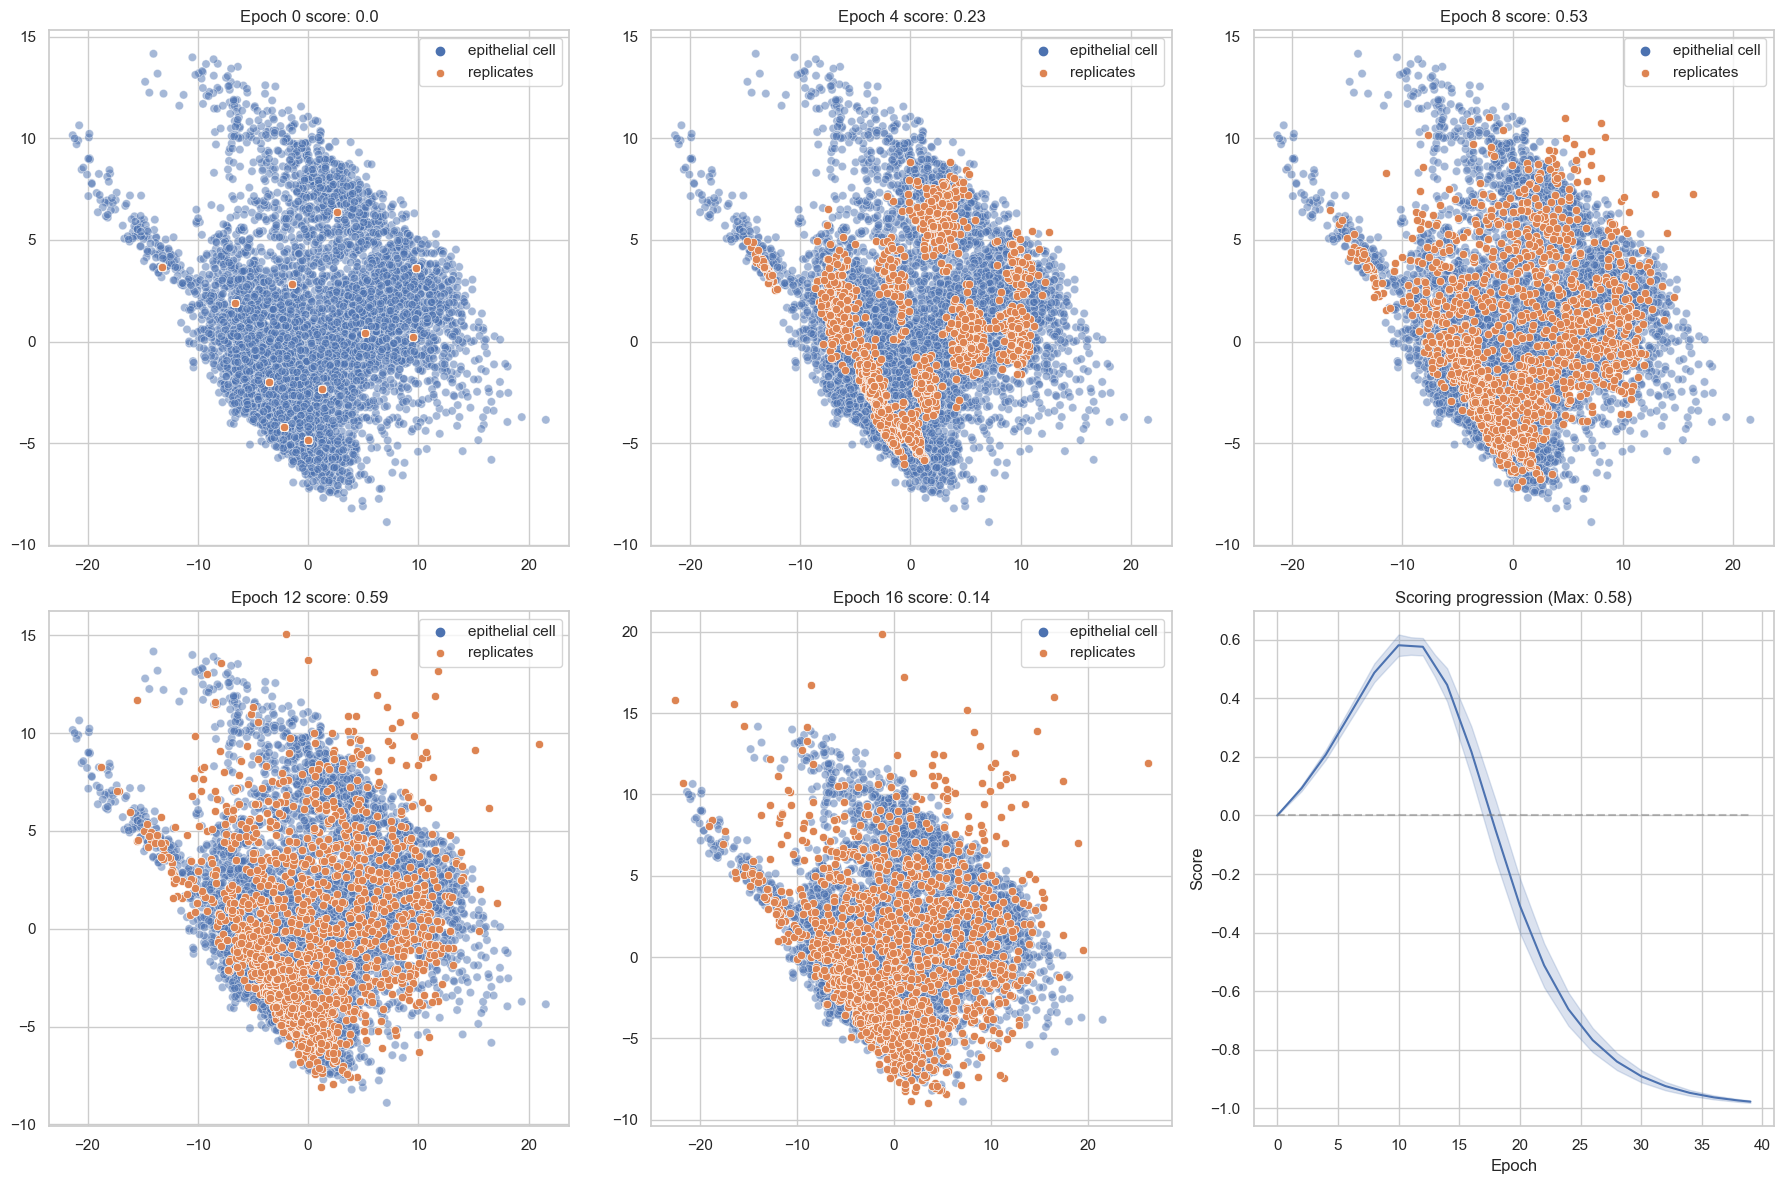

In [7]:
# select a subset of the full dataset comprised of different epithelial cells subtypes
cells_mask = metadata['cell_ontology_class'].isin(['epithelial cell'])
cells_labels = np.array(metadata['cell_ontology_class'].values[cells_mask])

# fit a PCA for plotting
pca_model = sklearn.decomposition.PCA(n_components=2)
cells_pca = pca_model.fit_transform(X[cells_mask])

# fit cytobench coverage estimator using only a portion of all the points for speedup
coverage_estimator = cytobench.CoverageEstimator(approx_p=.2)
coverage_estimator.fit(X[cells_mask])

# initial population to be expanded
expanded_population = np.copy(coverage_estimator.initial_points)

# gather score of initial population with respect to the reference empirical distribution

# plot initial population expansion on a 2x3 grid, flattening the axes for ease of iteration
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes, plot_every_n = axes.flatten(), 4

for i in range(5*plot_every_n):
    
    if i % plot_every_n == 0:

        expanded_population_pca = pca_model.transform(expanded_population)

        sns.scatterplot(x=cells_pca[:,0], y=cells_pca[:,1], alpha=.5, hue=cells_labels, ax=axes[i//plot_every_n])
        sns.scatterplot(x=expanded_population_pca[:,0], y=expanded_population_pca[:,1], label='replicates', ax=axes[i//plot_every_n])
        
        axes[i//plot_every_n].set_title(f'Epoch {i} score: {np.round(coverage_estimator.score(expanded_population), 2)}')
    
    # sample a new population by passing it through the VAE
    expanded_population = sample_fn(expanded_population)
    
# validate model with bootstrap
scores = np.array([
    cytobench.score_model(sample_fn, X[cells_mask], approx_p=.2, n_iterations=5*plot_every_n*2, score_every_n=2)
    for i in range(5)
])

# import to dataframe for ease of plotting
df = pd.DataFrame(scores).melt(var_name='Epoch', value_name='Score')

# lineplot with sd
sns.lineplot(data=df, x='Epoch', y='Score', errorbar='sd', ax=axes[-1])

# highlight null score and register max score in title
axes[-1].hlines(0, 0, df['Epoch'].max(), color='grey', alpha=.5, linestyles='--')
axes[-1].set_title(f'Scoring progression (Max: {np.round(scores.mean(axis=0).max(), 2)})')

plt.tight_layout()
plt.show()

# Advanced validation

Consider that PED only compares the empirical distributions as a whole.  
In order to develop reliable models for production environments we should be more stringent with our requirements, adding a layer of likelihood evaluation on the individual samples.  
Cytobench accepts a data validator as input to the scoring pipeline, which will be used to add a penalty proportional to the ratio of invalid samples; by default the penalty will scale quadratically in the number of invalid samples (param: validity_penalty_exp), but you might want to consider something even more taxing, as this might be too soft when using a conservative data validator

In [8]:
# let's train a simple validator using one component every 200 samples
validator = sklearn.pipeline.Pipeline(steps=[
    ('pca', sklearn.decomposition.PCA(n_components=8)),
    ('gmm', sklearn.mixture.GaussianMixture(n_components=sum(cells_mask) // 200, init_params='k-means++'))
]).fit(X[cells_mask])

threshold = np.quantile(validator.score_samples(X[cells_mask]), .01)

def validate_samples(X):
    return validator.score_samples(X) >= threshold

In [9]:
# prompt: fit a sklearn isolation forest to evaluate likelihood of sample points 

from sklearn.ensemble import IsolationForest

# Fit an Isolation Forest model to the data
isolation_forest = IsolationForest(contamination='auto', random_state=42)
isolation_forest.fit(X[cells_mask])

# Define a function to evaluate the likelihood of sample points
def validate_sample(X_sample):
  """
  Evaluates the likelihood of sample points using an Isolation Forest.

  Args:
    X_sample: A numpy array of sample points.

  Returns:
    A boolean numpy array indicating whether each sample point is valid.
  """
  return isolation_forest.predict(X_sample) == 1


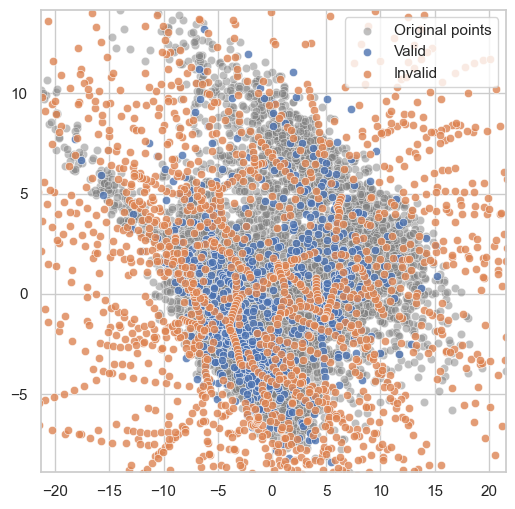

In [10]:
def extend_pair(x1, x2, points_per_line=30, extension_factor=3):
    
    # compute segment, extend and generate points
    direction = x2 - x1
    extended_line = np.linspace(x1 - extension_factor * direction, x2 + extension_factor * direction, points_per_line)
    
    # return points capped between 0 and 10 to increase likelihood with original data
    return np.clip(extended_line, 0, 10)

# select random points from the actual dataset
pairs = X[cells_mask][np.random.choice(sum(cells_mask), size=2 * 100, replace=False).reshape((-1, 2))]

# interpolate and extend
points = np.concatenate([ extend_pair(x1, x2) for x1, x2 in pairs ], axis=0)

# predict with validator and prepare for plotting
valid = validate_samples(points)
points_pca = pca_model.transform(points)

# visualize
plt.figure(figsize=(figsize, figsize))
sns.scatterplot(x=cells_pca[:,0], y=cells_pca[:,1], alpha=.5, color='grey', label='Original points')
sns.scatterplot(x=points_pca[valid][:,0], y=points_pca[valid][:,1], alpha=.8, label='Valid')
sns.scatterplot(x=points_pca[~valid][:,0], y=points_pca[~valid][:,1], alpha=.8, label='Invalid')

plt.xlim(cells_pca[:,0].min(), cells_pca[:,0].max())
plt.ylim(cells_pca[:,1].min(), cells_pca[:,1].max())

plt.show()


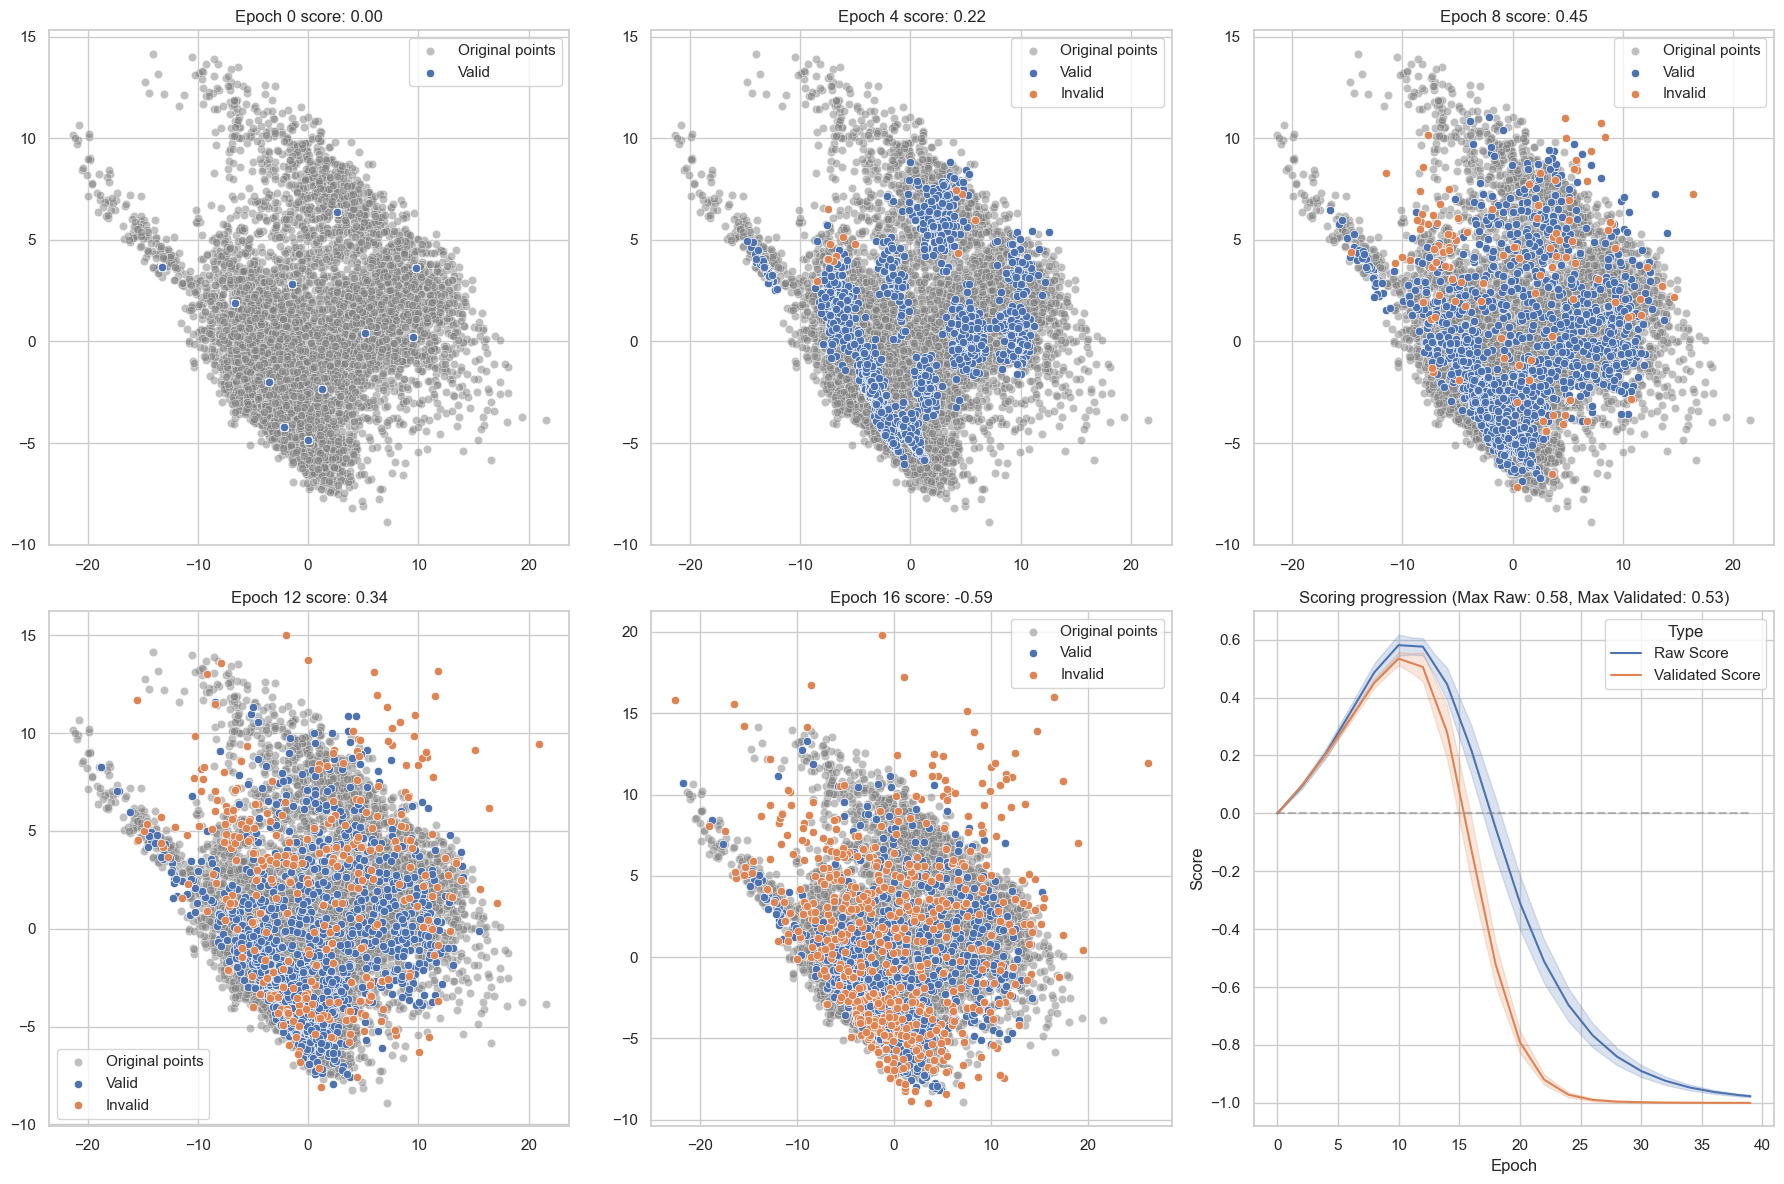

In [11]:
# add the validator fn to the coverage_estimator so we don't have to reinitialize it
coverage_estimator.validator = validate_samples

# initial population to be expanded
expanded_population = np.copy(coverage_estimator.initial_points)

# plot initial population expansion on a 2x3 grid, flattening the axes for ease of iteration
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes, plot_every_n = axes.flatten(), 4

for i in range(5*plot_every_n):
    
    if i % plot_every_n == 0:

        expanded_population_pca = pca_model.transform(expanded_population)
        valid = validate_samples(expanded_population)

        sns.scatterplot(x=cells_pca[:,0], y=cells_pca[:,1], alpha=.5, ax=axes[i//plot_every_n], color='grey', label='Original points')
        sns.scatterplot(x=expanded_population_pca[valid][:,0], y=expanded_population_pca[valid][:,1], label='Valid', ax=axes[i//plot_every_n])
        sns.scatterplot(x=expanded_population_pca[~valid][:,0], y=expanded_population_pca[~valid][:,1], label='Invalid', ax=axes[i//plot_every_n])
        
        axes[i//plot_every_n].set_title(f'Epoch {i} score: {coverage_estimator.score(expanded_population):.2f}')
    
    # sample a new population by passing it through the VAE
    expanded_population = sample_fn(expanded_population)
    
# validate model with bootstrap, passing the data validator
valid_scores = np.array([
    cytobench.score_model(sample_fn, X[cells_mask], data_validator=validate_samples, approx_p=.2, n_iterations=40, score_every_n=2)
    for i in range(5)
])

# import to dataframe for ease of plotting
df_raw = pd.DataFrame(scores).melt(var_name='Epoch', value_name='Score')
df_raw['Type'] = 'Raw Score'

df_valid = pd.DataFrame(valid_scores).melt(var_name='Epoch', value_name='Score')
df_valid['Type'] = 'Validated Score'

# combine both dataframes
df_combined = pd.concat([df_raw, df_valid])

# lineplot with sd
sns.lineplot(data=df_combined, x='Epoch', y='Score', hue='Type', errorbar='sd', ax=axes[-1])

# highlight null score and register max score in title
axes[-1].hlines(0, 0, df_combined['Epoch'].max(), color='grey', alpha=.5, linestyles='--')
axes[-1].set_title(f'Scoring progression (Max Raw: {np.round(scores.mean(axis=0).max(), 2)}, Max Validated: {np.round(valid_scores.mean(axis=0).max(), 2)})')

plt.tight_layout()
plt.show()

# Production environment

In general we will be interested in training a foundational model on a large dataset of samples, and then use this (eventually with a bit of fine-tuning) on external datasets eg. to do inference on molecular trajectories or increasing sample size  
In these cases you can leverage cytobench to estimate how well a model understands the manifold of interest (which may be comprised of many cell types) by having it expand the control group and monitor its score  
Note for the non bio scientists: when training your own foundational models it is essential to split the test set at the organismal level in order to prevent having samples highly correlated with ones in the training set

When working in production you should be careful with any quantile-normalized score below one, as the initial samples selected by cytobench are already excellent starting points to expand from, and thus you may want to decrease the resolution parameter in order to make the expansion more challenging. Consider that in this toy example it's almost impossible to not get at least .7 score with any sensible model, as any form of slightly manifold-aware noise will automatically ameliorate the overall coverage in a meaningful way (although this is in general much harder when dealing with thousands of dimensions and proper data validators)  
